<a href="https://colab.research.google.com/github/calamistratus/Whales_project/blob/main/Model_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output

# Making traditional machine learning model

The final result needs too be higher than 32%, because such result can be achived by simply making all the values "new_whale"

In [2]:
path = '/content/drive/MyDrive/Documents/rbns/'

train = np.load(path + 'train_array.npy')
test = np.load(path + 'test_array.npy')

df = pd.read_csv(path + 'train.csv')

h, w = 100, 200
n_train, n_test = train.shape[0], test.shape[0]

# Eigenfaces creation

The pictures are quite different and huge, so compressing them would not work, nor would building the model on pixels be reasonable, so I decided to use SKlearn's Eigenfaces

I have tried different amounts of components, none seemed to make any measurable differnce


In [3]:
from sklearn.decomposition import PCA

n_components = 100

pca = PCA(n_components, svd_solver='randomized', whiten=True).fit(train);

0


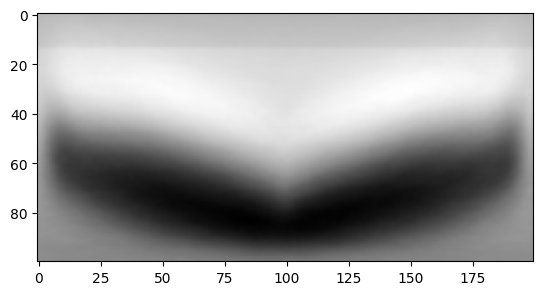

20


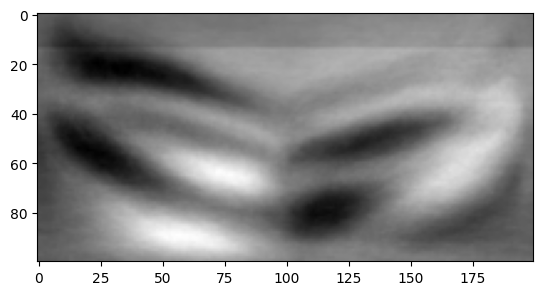

40


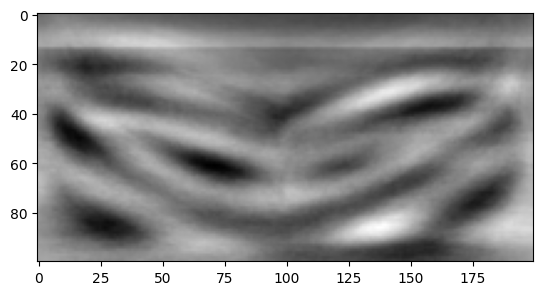

60


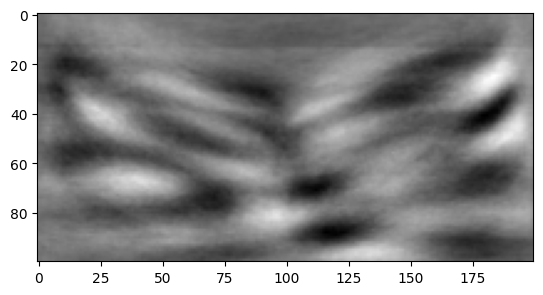

80


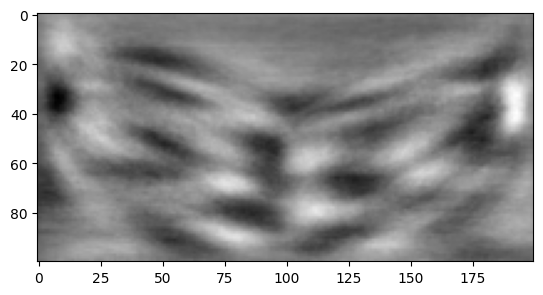

99


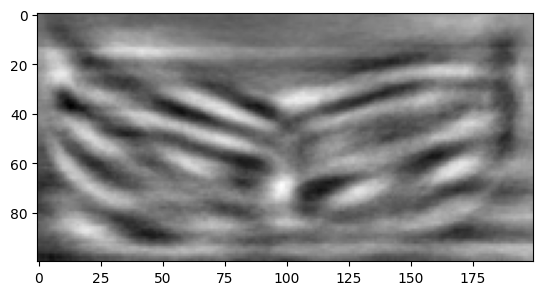

In [7]:
for n in np.append(np.arange(0, n_components, n_components//5), n_components-1):
  eigenface = pca.components_[n].reshape(h, w)
  plt.imshow(eigenface, cmap='gray')
  print(n)
  plt.show()

In [4]:
train_pca = pca.transform(train / 255.0)
test_pca = pca.transform(test / 255.0)

In [5]:
X = train_pca
y = df['Id']

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

n_classes = y.nunique()

sample_sub = pd.read_csv(path + 'sample_submission.csv')

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.05)

# Model building

Test size needs to be minuscule due to a huge number of classes

Due to the "new_whale" value being approximately 8% of the Dataset, the score needs to be at least higher than this value.

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Functions for simple model testing

def test_model(model, sample=None, random_state=42, return_model=False):

  if sample:
    sub_df = pd.DataFrame(X_train)
    sub_df['goal'] = np.array(y_train)
    sub_df = sub_df.sample(frac=sample, random_state=42)

    model.fit(sub_df.drop('goal', axis=1), sub_df['goal'])
  else:
    model.fit(X_train, y_train)

  preds = model.predict(X_test)

  print(accuracy_score(y_test, preds))
  if return_model:
    return model

def test_grid(model, param_grid, sample=None, random_state=42, verbose=2, cv=3, return_model=False):
  grid = GridSearchCV(model, param_grid, scoring='accuracy', cv=cv, verbose=verbose)

  if sample:
    sub_df = pd.DataFrame(X_train)
    sub_df['goal'] = np.array(y_train)
    sub_df = sub_df.sample(frac=sample, random_state=random_state)

    grid.fit(sub_df.drop('goal', axis=1), sub_df['goal'])
  else:
    grid.fit(X_train, y_train)
  preds = grid.predict(X_test)

  print(accuracy_score(y_test, preds))
  print(grid.best_params_)
  if return_model:
    return grid

# SVM

After trying many kernels and going through the grid search, I can safely assume that this is not the best approach for such data

In [ ]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

param_grid = {'estimator__kernel' : ['poly', 'linear', 'rbf', 'sigmoid'],
              'estimator__C' : [.01, 1, 100]}

svc_grid = test_grid(OneVsRestClassifier(SVC()), param_grid, cv=4, verbose=0, return_model=True)    # Best I can pull out of SVC in this scenario

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


0.09939148073022312
{'estimator__C': 100, 'estimator__kernel': 'rbf'}


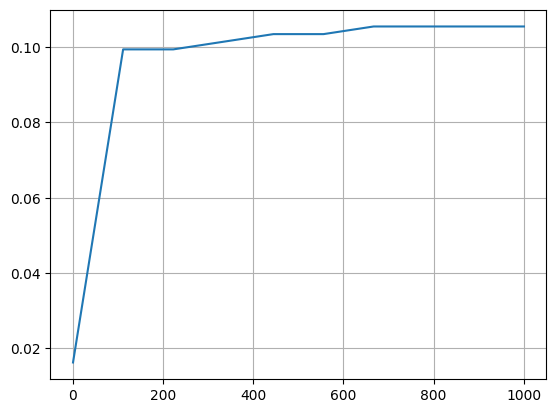

In [ ]:
  from sklearn.neighbors import KNeighborsClassifier

errors = []
nrange = np.linspace(1, 1000, 10).astype(int)

for n in nrange:
  svc = OneVsRestClassifier(SVC(C=n)).fit(X_train, y_train)

  preds = svc.predict(X_test)

  errors.append(accuracy_score(y_test, preds))

plt.plot(nrange, errors)
plt.grid(True)
plt.show()

# Trees

Trees proved to be long in training and inefficient, but

In [ ]:
from sklearn.tree import DecisionTreeClassifier

test_model(DecisionTreeClassifier(max_depth=1))

test_model(DecisionTreeClassifier(max_depth=5), return_model=True)

dtc = test_model(DecisionTreeClassifier(max_depth=10), return_model=True)   # Same value

0.07707910750507099
0.07707910750507099
0.07707910750507099


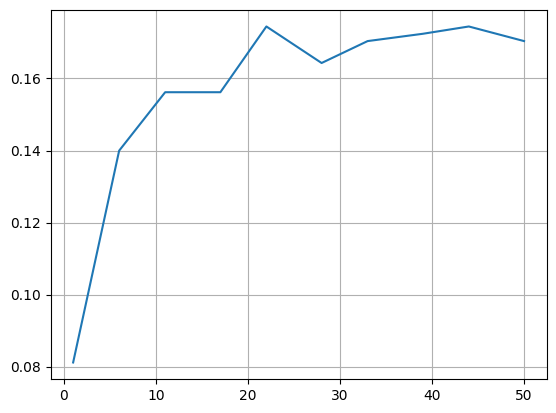

In [12]:
from sklearn.ensemble import RandomForestClassifier
errors = []
nrange = np.linspace(1, 50, 10).astype(int)

for n in nrange:
  print(n, end=' / ')
  rfc = RandomForestClassifier(n_estimators=n).fit(X_train, y_train)

  preds = rfc.predict(X_test)

  errors.append(accuracy_score(y_test, preds))

clear_output()
plt.plot(nrange, errors)
plt.grid(True)
plt.show()

In [13]:
from sklearn.ensemble import RandomForestClassifier

test_model(RandomForestClassifier(n_estimators=30))

0.1663286004056795


In [15]:
from sklearn.ensemble import ExtraTreesClassifier

etc = test_model(ExtraTreesClassifier(n_estimators=50), return_model=True)

0.18661257606490872


# KNN

Does not work alone in this database unfortunately due to a big amount of 'new_whale' values.

Although it gives the most individual whale spicies, which could be quite useful later

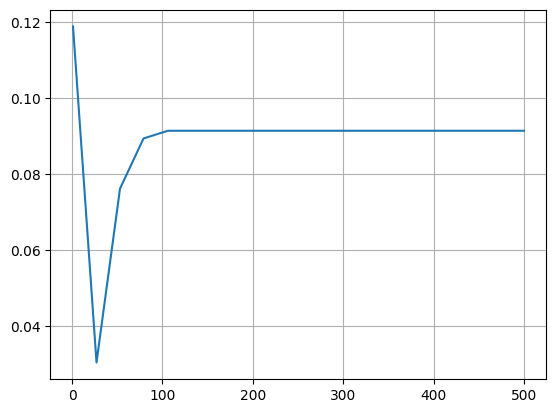

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

errors = []
nrange = np.linspace(1, 500, 20).astype(int)

for n in nrange:
  knn = KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)

  preds = knn.predict(X_test)

  errors.append(accuracy_score(y_test, preds))

plt.plot(nrange, errors)
plt.grid(True)
plt.show()

In [16]:
from sklearn.neighbors import KNeighborsClassifier

knn = test_model(KNeighborsClassifier(1), return_model=True)

0.12170385395537525


# Gaussian naive bias

The most effective model for eigenfaces recognition. Proved itself as fast and relatively accurate again, but the final result is still worse than 32% no matter the tuning.

In [19]:
from sklearn.naive_bayes import GaussianNB

gnb = test_model(GaussianNB(), return_model=True)   # Surprisingly good

0.15010141987829614


In [ ]:
param_grid = {'var_smoothing' : [1, 1e-3, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11]}

gnb_grid = test_grid(GaussianNB(), param_grid, cv=3, verbose=0)    # Is not tune-able

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


0.19066937119675456
{'var_smoothing': 0.001}


# Trying MLPClassifier

My attemts at it were barely succesful, mostly because of the sheer time it takes to train one model. Most end up at 10 percent, which is worse than Gaussian bias.

I see a huge potential though. I will attemt to solve this problem using DL.

The results don't differ from one layer of N neurons to another, which is quite strange.

In [15]:
from sklearn.neural_network import MLPClassifier

test_model(MLPClassifier(max_iter=1000, hidden_layer_sizes=(10)))

0.09127789046653144


In [13]:
from sklearn.neural_network import MLPClassifier

test_model(MLPClassifier(max_iter=1000, hidden_layer_sizes=(10, 10)))

0.09127789046653144


In [14]:
from sklearn.neural_network import MLPClassifier

test_model(MLPClassifier(max_iter=1000, hidden_layer_sizes=(50)))

0.09127789046653144


# Combining models

Combining to "soft" models with KNN, which almost always gives individual spicies gave the best result of all, almost 40%

In [26]:
from sklearn.ensemble import VotingClassifier

vc = test_model(VotingClassifier([('etc', etc), ('knn', knn), ('gnb', gnb)]), return_model=True)

0.18864097363083165


In [23]:
best = vc.fit(X, y)
preds = best.predict(test_pca)

sub = pd.DataFrame({'Image': sample_sub['Image'], 'Id': preds})
sub = sub.set_index('Image')

sub.to_csv('whales_sub.csv')    # Final score of 0.395